In [28]:
import os
import pandas as pd

current_dir = os.getcwd()
final_path = os.path.join(current_dir, '..', 'data', 'final', 'final.csv')
selected_path = os.path.join(current_dir, '..', 'data', 'final', 'selected.csv')

final_df = pd.read_csv(final_path)
selected_df = pd.read_csv(selected_path).values

### Przygotowanie danych

In [29]:
from util import prepare_final

final_df = prepare_final(final_df)

final_df.head()

,premium_user,popularity_mean,popularity_std,popularity_min,popularity_max,duration_ms_mean,duration_ms_std,duration_ms_min,duration_ms_max,explicit_ratio,...,q,r,s,t,u,v,w,x,y,z
0,False,-0.997069,-0.995204,-0.319064,-0.994713,-1.059379,-0.409611,-0.430490,-0.491912,-1.065425,...,0,1,0,1,1,0,1,0,0,0
1,False,1.066575,0.740434,2.270742,0.713372,0.661699,-0.043242,1.994549,-0.098518,0.176852,...,0,1,0,1,0,1,1,0,0,0
2,False,-0.997069,-0.995204,-0.319064,-0.994713,-1.429353,-0.963033,0.339053,-0.735753,-0.814081,...,0,1,1,0,1,0,0,0,0,0
3,False,-0.997069,-0.995204,-0.319064,-0.994713,-1.192440,-0.607767,-1.304843,-0.491912,-0.613005,...,0,1,0,1,1,1,1,0,1,0
4,False,1.056186,1.104850,0.544205,0.968310,0.678373,-0.770022,0.842162,-0.812626,2.439812,...,0,1,1,1,1,0,0,0,0,0


In [30]:
from sklearn.model_selection import train_test_split

X = final_df.drop('premium_user', axis=1).values
y = final_df['premium_user'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_selected, X_test_selected, _, _ = train_test_split(selected_df, y, test_size=0.2, random_state=42)

### Klasyfikatora XGboost

Szukanie parametrów

In [47]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [51]:
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
    min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
    param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)

gsearch1.fit(X_train_selected, y_train)

print("Best parameters found: ", gsearch1.best_params_)
print("Best score: ", gsearch1.best_score_)

Best parameters found:  {'max_depth': 3, 'min_child_weight': 5}
Best score:  0.8651943552010042


In [55]:
param_test2 = {
    'max_depth':[2,3,4],
    'min_child_weight':[4,5,6]
}

gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
    min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
    param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)

gsearch2.fit(X_train_selected, y_train)

print("Best parameters found: ", gsearch2.best_params_)
print("Best score: ", gsearch2.best_score_)

Best parameters found:  {'max_depth': 3, 'min_child_weight': 6}
Best score:  0.8653520345937828


In [56]:
param_test2b = {
    'min_child_weight':[6,8,10,12]
}

gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=3,
    min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
    param_grid = param_test2b, scoring='roc_auc',n_jobs=4, cv=5)

gsearch2b.fit(X_train_selected, y_train)

print("Best parameters found: ", gsearch2b.best_params_)
print("Best score: ", gsearch2b.best_score_)

Best parameters found:  {'min_child_weight': 8}
Best score:  0.8654497289417528


In [57]:
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=3,
    min_child_weight=8, gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
    param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)

gsearch3.fit(X_train_selected, y_train)

print("Best parameters found: ", gsearch3.best_params_)
print("Best score: ", gsearch3.best_score_)

Best parameters found:  {'gamma': 0.0}
Best score:  0.8654497289417528


In [58]:
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=177, max_depth=3,
    min_child_weight=8, gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
    param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)

gsearch4.fit(X_train_selected, y_train)

print("Best parameters found: ", gsearch4.best_params_)
print("Best score: ", gsearch4.best_score_)

Best parameters found:  {'colsample_bytree': 0.7, 'subsample': 0.7}
Best score:  0.865638006324479


In [61]:
param_test4b = {
    'subsample':[i/100.0 for i in range(65,80,5)],
    'colsample_bytree':[i/100.0 for i in range(60,80,5)]
}

gsearch4b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=177, max_depth=3,
    min_child_weight=8, gamma=0, subsample=0.7, colsample_bytree=0.7,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
    param_grid = param_test4b, scoring='roc_auc',n_jobs=4, cv=5)

gsearch4b.fit(X_train_selected, y_train)

print("Best parameters found: ", gsearch4b.best_params_)
print("Best score: ", gsearch4b.best_score_)

Best parameters found:  {'colsample_bytree': 0.75, 'subsample': 0.65}
Best score:  0.865718752937968


In [64]:
param_test5 = {
    'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 100]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=177, max_depth=3,
    min_child_weight=8, gamma=0, subsample=0.65, colsample_bytree=0.75,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
    param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)

gsearch5.fit(X_train_selected, y_train)

print("Best parameters found: ", gsearch5.best_params_)
print("Best score: ", gsearch5.best_score_)

Best parameters found:  {'reg_alpha': 0}
Best score:  0.865718752937968


Uczenie

In [65]:
clf = XGBClassifier(
    learning_rate=0.01,
    n_estimators=5000,
    max_depth=3,
    min_child_weight=8,
    gamma=0,
    subsample=0.65,
    colsample_bytree=0.75,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    reg_alpha=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

Accuracy: 0.79
ROC AUC: 0.86


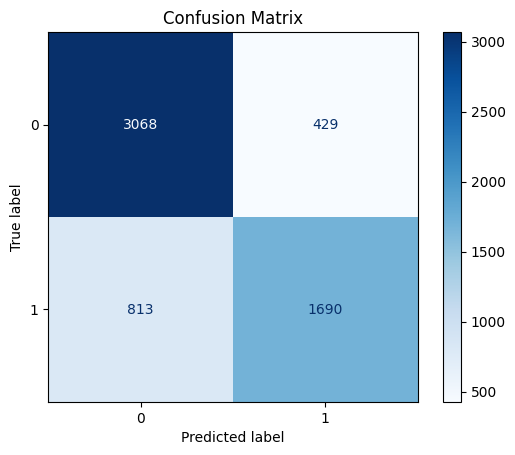

In [66]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC: {roc_auc:.2f}')

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Po selekcji atrybutów

In [41]:
clf_selected = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf_selected.fit(X_train_selected, y_train)

y_pred_selected = clf_selected.predict(X_test_selected)
y_pred_proba_selected = clf_selected.predict_proba(X_test_selected)[:, 1]

Accuracy: 0.78
ROC AUC: 0.84


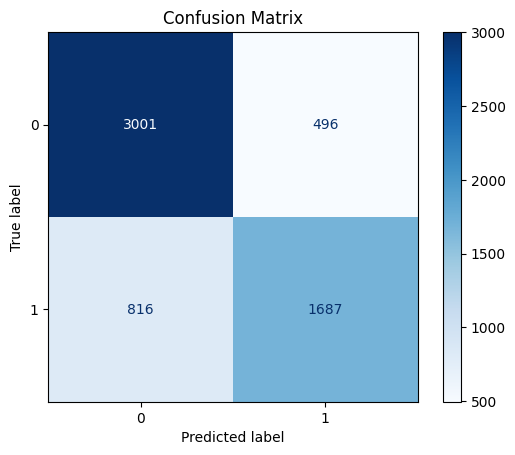

In [42]:
accuracy = accuracy_score(y_test, y_pred_selected)
print(f'Accuracy: {accuracy:.2f}')

roc_auc = roc_auc_score(y_test, y_pred_proba_selected)
print(f'ROC AUC: {roc_auc:.2f}')

cm = confusion_matrix(y_test, y_pred_selected)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Save models

In [35]:
import joblib

model_path = os.path.join(current_dir, 'trained', 'xgb_model.joblib')
model_selected_path = os.path.join(current_dir, 'trained', 'xgb_selected_model.joblib')

joblib.dump(clf, model_path)
joblib.dump(clf_selected, model_selected_path)

['c:\\_prog\\vm_shared\\Account-Classifier\\models\\trained\\xgb_selected_model.joblib']